In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [2]:
import pandas as pd
import numpy as np

import  matplotlib.pyplot as plt
import pickle

from chemistry import Molecule
from util import score
from pprint import pprint


In [3]:
with open('../data/molecules_enh.pickle', 'rb') as f:
    molecules = pickle.load(f)

In [4]:
structures = pd.read_feather('../data/structures_enh.feather')
molecules_df = pd.read_feather('../data/molecules.feather')
labelled = pd.read_feather('../data/train.feather')
unlabelled = pd.read_feather('../data/test.feather')

In [5]:
labelled_enh = labelled.merge(molecules_df, left_on='molecule_name', right_on='molecule_name')
#labelled_enh.head(32)

In [6]:
unlabelled_enh = unlabelled.merge(molecules_df, left_on='molecule_name', right_on='molecule_name')
#unlabelled_enh.head(32)

In [7]:
len(labelled), len(labelled_enh)

(4658147, 4658147)

In [8]:
from models import SKModel, partition_data

#data_df = labelled[labelled.type == '1JHC'].head(10)
data_df = labelled_enh.head(1000)
train_df, test_df = partition_data(data_df, train_frac=1)
train_df = train_df.copy()
        
model = SKModel(molecules=molecules,
                structures=structures)
model.setup_data(train_df, train_df)

In [9]:
model.structures.columns

Index(['molecule_name', 'atom_index', 'atom', 'x', 'y', 'z', 'x_mean',
       'y_mean', 'z_mean', 'dist_to_mean'],
      dtype='object')

In [11]:
list(model.input_df.columns)

['id',
 'molecule_name',
 'atom_index_0',
 'atom_index_1',
 'type',
 'scalar_coupling_constant',
 'nC',
 'nF',
 'nH',
 'nN',
 'nO',
 'nCNOF',
 'nCN',
 'nOF',
 'nAtoms',
 'coupling_distance',
 'atom_0',
 'atom_1',
 'coupling_3JHH',
 'coupling_3JHN',
 'coupling_1JHN',
 'coupling_2JHN',
 'coupling_1JHC',
 'coupling_2JHH',
 'coupling_2JHC',
 'coupling_3JHC',
 'atom0_C',
 'atom0_F',
 'atom0_O',
 'atom0_H',
 'atom0_N',
 'atom0_weight',
 'ai',
 'atom0_x',
 'atom0_y',
 'atom0_z',
 'atom0_x_mean',
 'atom0_y_mean',
 'atom0_z_mean',
 'atom0_dist_to_mean',
 'atom0_fi',
 'atom0_simple_fi',
 'atomN_C',
 'atomN_F',
 'atomN_O',
 'atomN_H',
 'atomN_N',
 'atomN_weight',
 'atomN_x',
 'atomN_y',
 'atomN_z',
 'atomN_x_mean',
 'atomN_y_mean',
 'atomN_z_mean',
 'atomN_dist_to_mean',
 'atomN_fi',
 'atomN_simple_fi',
 'atom1_C',
 'atom1_F',
 'atom1_O',
 'atom1_H',
 'atom1_N',
 'atom1_weight',
 'atom1_x',
 'atom1_y',
 'atom1_z',
 'atom1_x_mean',
 'atom1_y_mean',
 'atom1_z_mean',
 'atom1_dist_to_mean',
 'atom1_f

In [24]:
model.input_df.dtypes

id                             int32
molecule_name                 object
atom_index_0                   int16
atom_index_1                   int16
type                        category
scalar_coupling_constant     float32
nC                              int8
nF                              int8
nH                              int8
nN                              int8
nO                              int8
nCNOF                           int8
nCN                             int8
nOF                             int8
nAtoms                          int8
coupling_distance            float32
atom_0                      category
atom_1                      category
coupling_1JHN                   int8
coupling_2JHC                   int8
coupling_3JHH                   int8
coupling_3JHN                   int8
coupling_3JHC                   int8
coupling_2JHN                   int8
coupling_1JHC                   int8
coupling_2JHH                   int8
atom0_C                         int8
a

In [12]:
labelled_enh.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,nC,nF,nH,nN,nO,nCNOF,nCN,nOF,nAtoms
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807602,1,0,4,0,0,1,1,0,5
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000,1,0,4,0,0,1,1,0,5
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254800,1,0,4,0,0,1,1,0,5
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300,1,0,4,0,0,1,1,0,5
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807404,1,0,4,0,0,1,1,0,5


In [13]:
import itertools

In [46]:
from models import LGBModel
from models import partition_data

# atom_count_ranges = [(1, 10), (11, 15), (16, 20), (21, 25), (26, 30)]
# C_count_ranges = [(1, 5), (6, 6), (7, 7), (8, 9)]
coupling_types = sorted(labelled_enh.type.unique())[0:1]
def test(data, count=5000):
    global model
    
    plt.figure(figsize=(25, 25))
#     for i, (t, (min_atoms, max_atoms)) in enumerate(itertools.product(coupling_types, C_count_ranges), 1):
    for i, t in enumerate(coupling_types, 1):    
#         data_df = data[(data.type == t) & (data.nC >= min_atoms) & (data.nC <= max_atoms)]
        data_df = data[data.type == t].head(count)

        train_df, test_df = partition_data(data_df)
        
        if len(train_df) < 10 or len(test_df) < 10:
            continue
            
        print(f'Training {len(train_df)} samples for {t}')

        model = LGBModel(dict(molecules=molecules, 
                              structures=structures),
                         dict(n_jobs=8,
                              max_depth=9,
                              boosting_type='gbdt',
                              num_leaves=128,
                              min_child_samples=20,
                              learning_rate=0.1,
                              n_estimators=1000,
                              reg_alpha=0.1,
                              reg_lambda=0.3,
                              subsample_freq = 1,
                              subsample = 0.9,
                              num_iterations=100,
#                               verbose=500
                             ))
  

        model.fit(train_df, train_df)
        output, score = model.evaluate(test_df, test_df)
        
        print(f'{t} score: {score} (trained on {len(train_df)} elements)')
        plt.subplot(4, 4, 2 * i - 1)
        plt.plot(test_df.scalar_coupling_constant, output, '*')
        mn = min(test_df.scalar_coupling_constant.min(), output.min())
        mx = min(test_df.scalar_coupling_constant.max(), output.max())
        plt.plot([mn, mx], [mn, mx])
        plt.title(t)
        
        plt.subplot(4, 4, 2 * i - 1)
        plt.plot(history)
    plt.show()
        
test(labelled_enh, 50000)


Training 35000 samples for 1JHC


IndexError: boolean index did not match indexed array along dimension 0; dimension is 35000 but corresponding boolean dimension is 15000

<Figure size 1800x1800 with 0 Axes>

Axes(0,0;1x1)


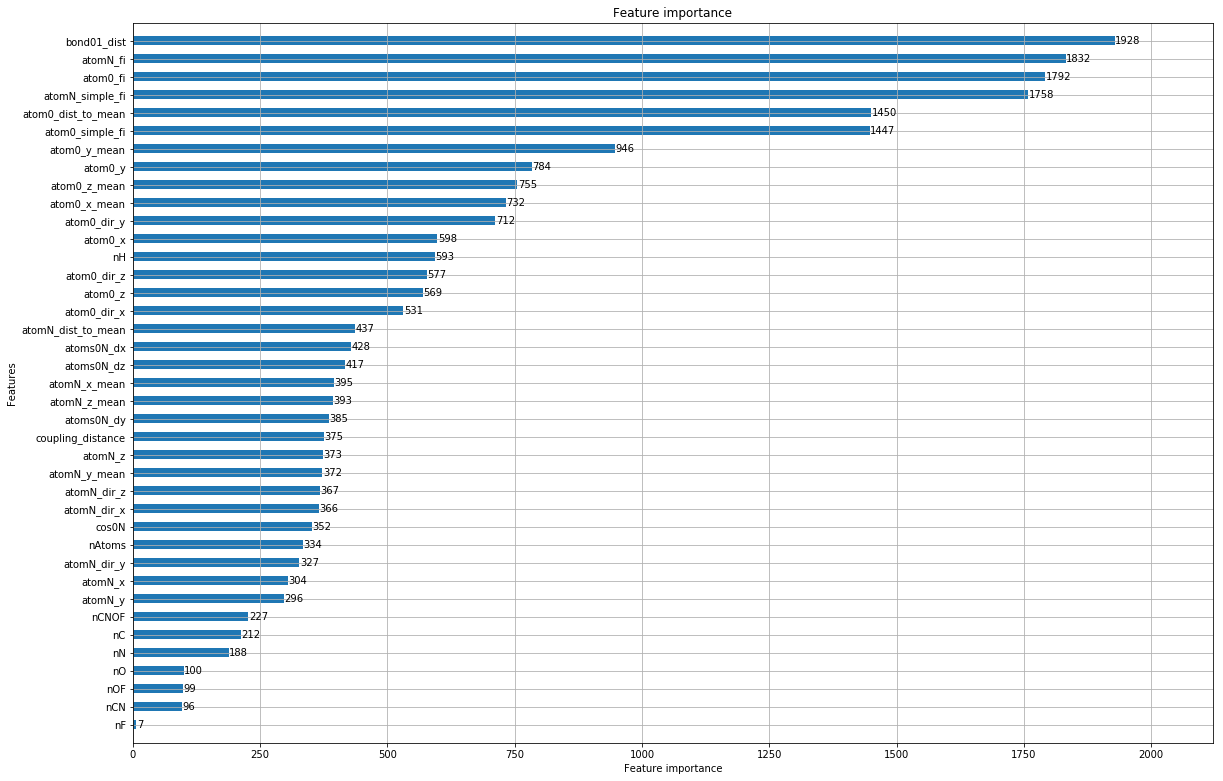

In [44]:
from models import LGBModel
fig = plt.figure(figsize=(15, 10))
model.plot_importance(ax=fig.add_axes([0, 0, 1, 1]), height=0.5)
plt.show()

In [28]:
def train(data):
    models = {}
    for t in sorted(data.type.unique()):
        train_df = data[data.type == t]
        print(f'Training {len(train_df)} samples for {t}')
        model = LGBModel(dict(molecules=molecules, 
                              structures=structures),
                         dict(n_jobs=8,
                              max_depth=9,
                              boosting_type='gbdt',
                              num_leaves=128,
                              min_child_samples=20,
                              learning_rate=0.2,
                              n_estimators=1000,
                              reg_alpha=0.1,
                              reg_lambda=0.3,
                              subsample_freq = 1,
                              subsample = 0.9))
        models[t] = model
        model.fit(train_df, train_df)
    
    return models

models = train(labelled_enh)

Training 709416 samples for 1JHC
Training 43363 samples for 1JHN
Training 1140674 samples for 2JHC
Training 378036 samples for 2JHH
Training 119253 samples for 2JHN
Training 1510379 samples for 3JHC
Training 590611 samples for 3JHH
Training 166415 samples for 3JHN


In [29]:
def predict(data, models):
    out_df = None
    
    for t in sorted(data.type.unique()):
        predict_df = data[data.type == t]
        print(f'Predicting {len(predict_df)} samples for {t}')
        output = models[t].predict(predict_df)
        
        id = predict_df['id']
        out_df_coupling = pd.DataFrame(data={'id':id, 'scalar_coupling_constant':output}, index=predict_df.index)
        
        if out_df is None:
            out_df = out_df_coupling
        else:
            out_df = out_df.append(out_df_coupling).sort_index()

    return out_df.sort_index()
    
#%prun -s cumulative f(unlabelled.head(10000))
prediction = predict(unlabelled_enh, models)

Predicting 380609 samples for 1JHC
Predicting 24195 samples for 1JHN
Predicting 613138 samples for 2JHC
Predicting 203126 samples for 2JHH
Predicting 64424 samples for 2JHN
Predicting 811999 samples for 3JHC
Predicting 317435 samples for 3JHH
Predicting 90616 samples for 3JHN


In [30]:
prediction.head()

,id,scalar_coupling_constant
0,4658147,24.510750
1,4658148,177.117127
2,4658149,1.882473
3,4658150,173.697553
4,4658151,23.688759


In [31]:
prediction.to_csv('../data/pred.csv',index=False)